In [2]:
import pandas as pd
import numpy as np
from ScanImageTiffReader import ScanImageTiffReader
import os
import matplotlib.pyplot as plt
import scipy.signal
import tifffile
from scipy.signal import butter, lfilter,find_peaks, gaussian, convolve
from ibllib.io.video import *
import scipy.ndimage
import cv2
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import HTML
from matplotlib.animation import PillowWriter
from ScanImageTiffReader import ScanImageTiffReader
import json
from murphlib.caimage import *
from murphlib.tools import *
from murphlib.plotting import *
from murphlib.regression import *
from sklearn.decomposition import PCA
from sklearn.metrics import explained_variance_score
from scipy.stats import zscore
import scipy.io
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import fcluster
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score
plt.rcParams['animation.ffmpeg_path'] = r'D:\ffmpeg\bin\ffmpeg.exe'

In [3]:
mouse_path = r'Z:\TM_Lab\Edward\Cerebellum_Imaging\Pcp2-jgcamp8m\A_R2'
subdir = [d for d in os.listdir(mouse_path)]
dates = [s for s in subdir if s.isdigit()]
# dates = [
#     # '20240815',
#     # '20240821',
#     '20240904',
#     '20240910',
#     '20240918',
#     '20240924',
#     '20241015',
#     '20241018',
#     '20241106',
#     '20241111',
#     #'20241115',
#     '20241118',
#     #'20241119',
# ]
tv = np.load(r'D:\Lab_Analysis\allenCCF\template_volume_10um.npy')
atlas_template = np.squeeze(tv[1049:1280, 139, 299:840])
mouse_data = {key: {} for key in dates}
for date in dates:
    session_path = os.path.join(mouse_path, date)
    bhv_path = os.path.join(session_path, 'behavior')
    subdir = [d for d in os.listdir(session_path)]
    if 'arm1' in subdir:
        arm1_img_path = os.path.join(session_path, 'arm1')
        arm1_stat = get_stat_with_coord(arm1_img_path)
        arm1_ridge_model = np.load(os.path.join(arm1_img_path, 'ridge_model.npy'), allow_pickle=True)
        predictors = arm1_ridge_model[0]['predictors']
        unique_predictors = arm1_ridge_model[0]['unique_predictors']
        arm1_stat = attach_reg_model_to_stat(arm1_stat, arm1_ridge_model)
        mouse_data[date]['arm1'] = np.array(arm1_stat, dtype=object)

    if 'arm2' in subdir:
        arm2_img_path = os.path.join(session_path, 'arm2')
        arm2_stat = get_stat_with_coord(arm2_img_path)
        arm2_ridge_model = np.load(os.path.join(arm2_img_path, 'ridge_model.npy'), allow_pickle=True)
        predictors = arm2_ridge_model[0]['predictors']
        unique_predictors = arm2_ridge_model[0]['unique_predictors']
        arm2_stat = attach_reg_model_to_stat(arm2_stat, arm2_ridge_model)
        mouse_data[date]['arm2'] = np.array(arm2_stat, dtype=object)
mouse_id = mouse_path.split('\\')[-1]
os.makedirs(os.path.join(mouse_path, 'figures'), exist_ok=True)
    

In [14]:
preds = unique_predictors[:11]
for pred in preds:
    pred_idx = [i for i, name in enumerate(predictors) if pred in name]

    fig, axes = plt.subplots(3,3,figsize = (30,15))
    fig.suptitle(mouse_id + ' ' + pred, fontsize=16)
    for dayi, date in enumerate(dates):
        
        axes[dayi//3, dayi%3].imshow(atlas_template,cmap='gray')
        axes[dayi//3, dayi%3].set_title(date)
        axes[dayi//3, dayi%3].set_xticks([])
        axes[dayi//3, dayi%3].set_yticks([])
        if 'arm1' in mouse_data[date]:
            for i, neuron in enumerate(mouse_data[date]['arm1']):
                beta = zscore(neuron['beta'][pred_idx])
                midpoint = (len(beta)+1)//2
                resp_beta = np.mean(beta[midpoint:midpoint+int(0.4*15)])
                #print(resp_beta)
                axes[dayi//3, dayi%3].scatter(neuron['xcoord_atlas'], neuron['ycoord_atlas'], c=np.repeat(resp_beta,len(neuron['xcoord_atlas'])), cmap='coolwarm', vmin = -2, vmax = 2, s=0.001)
        if 'arm2' in mouse_data[date]:
            for i, neuron in enumerate(mouse_data[date]['arm2']):
                beta = zscore(neuron['beta'][pred_idx])
                midpoint = (len(beta)+1)//2
                resp_beta = np.mean(beta[midpoint:midpoint+int(0.4*15)])
                #print(resp_beta)
                axes[dayi//3, dayi%3].scatter(neuron['xcoord_atlas'], neuron['ycoord_atlas'], c=np.repeat(resp_beta,len(neuron['xcoord_atlas'])), cmap='coolwarm', vmin = -2, vmax = 2, s=0.001)
    fig.tight_layout()
    fig.savefig(os.path.join(mouse_path, 'figures', 'ridge_beta_'+ pred + '_topo.png'),
                dpi=300,               # High resolution for publication
                bbox_inches='tight',   # Prevent clipping
                )
    plt.close(fig)

In [4]:
preds = unique_predictors[:10]
keys = ['mouse_id', 'beta_timepoint', 'predictors', 'num_predictors', 
            'date', 'arm', 'atlas_xcoord', 'atlas_ycoord', 'lin_xcoord', 'lin_ycoord']
beta_keys = [pred+'_beta' for pred in preds]
psth_keys = [pred+'_psth' for pred in preds]
keys = keys + beta_keys + psth_keys

neuron_data = {key:None for key in keys}
neuron_data['mouse_id'] = mouse_id
neuron_data['beta_timepoint'] = np.linspace(-1000, 1000, 31)
neuron_data['predictors'] = preds
neuron_data['num_predictors'] = len(preds)
for key in keys:
    if neuron_data[key] is not None:
        pass
    elif 'beta' in key and neuron_data[key] is None:
        neuron_data[key] = np.array([])
    elif 'psth' in key and neuron_data[key] is None:
        neuron_data[key] = np.array([])
    else: 
        neuron_data[key] = []
time_start = neuron_data['beta_timepoint'][0]//1000
time_end = neuron_data['beta_timepoint'][-1]//1000

for predi, pred in enumerate(preds):
    pred_idx = [i for i, name in enumerate(predictors) if pred in name]
    for dayi, date in enumerate(dates):
        session_path = os.path.join(mouse_path, date)
        if 'arm1' in mouse_data[date]:
            
            stat = mouse_data[date]['arm1']
            arm1_img_path = os.path.join(session_path, 'arm1')
            arm1_table_for_img = pd.read_csv(arm1_img_path+'\\table_for_img.csv')
            with open(os.path.join(arm1_img_path, 'ca_img_wholefile_metadata.json'), 'r') as json_file:
                arm1_img_meta = json.load(json_file)
            frame_rate_arm1 = arm1_img_meta['SI.hRoiManager.scanFrameRate']
            arm1_dff = np.load(os.path.join(arm1_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'))    

            tf_arm1_table_for_img = transform_trial_table(arm1_table_for_img)
            psth_frame_idx = find_frame_indices(tf_arm1_table_for_img, frame_rate_arm1, (time_start, time_end), pred).astype(int)
            all_psth = get_trial_PSTH(arm1_dff, psth_frame_idx, zscore=False)
            mean_psth = np.mean(all_psth, axis=0)
            mean_psth = zscore(mean_psth, axis=1)
            
            aspect_ratio = np.array([stat[i]['aspect_ratio'] for i in range(len(stat))])
            npix = np.array([stat[i]['npix'] for i in range(len(stat))])
            pc_idx = np.where((aspect_ratio<1.1) & (npix<120) & (npix>100))[0]
            dd_idx = np.where((aspect_ratio>1.1) | (npix>120) | (npix<100))[0]
            for i, neuron in enumerate(mouse_data[date]['arm1']):
                if i in pc_idx:
                    continue
                beta = zscore(neuron['beta'][pred_idx])
                psth = mean_psth[i,:]
                if neuron_data[pred+'_beta'].size == 0:
                    # Initialize as 2D array with the shape of the new beta
                    neuron_data[pred+'_beta'] = beta[np.newaxis, :]
                    neuron_data[pred+'_psth'] = psth
                else:
                    # Stack the new beta vertically
                    neuron_data[pred+'_beta'] = np.vstack([neuron_data[pred+'_beta'], beta])
                    neuron_data[pred+'_psth'] = np.vstack([neuron_data[pred+'_psth'], psth])
                if predi == 0: 
                    neuron_data['date'].append(date)
                    neuron_data['arm'].append('arm1')
                    neuron_data['atlas_xcoord'].append(neuron['xcoord_atlas']) # len should equal rows of beta
                    neuron_data['atlas_ycoord'].append(neuron['ycoord_atlas'])
                    neuron_data['lin_xcoord'].append(neuron['xcoord_lin'])
                    neuron_data['lin_ycoord'].append(neuron['ycoord_lin'])
        if 'arm2' in mouse_data[date]:
            
            stat = mouse_data[date]['arm2']
            arm2_img_path = os.path.join(session_path, 'arm2')
            arm2_table_for_img = pd.read_csv(arm2_img_path+'\\table_for_img.csv')
            with open(os.path.join(arm2_img_path, 'ca_img_wholefile_metadata.json'), 'r') as json_file:
                arm2_img_meta = json.load(json_file)
            frame_rate_arm2 = arm2_img_meta['SI.hRoiManager.scanFrameRate']
            arm2_dff = np.load(os.path.join(arm2_img_path, 'dff_moving_percentile_pc_lowpass_0p5hz.npy'))    

            tf_arm2_table_for_img = transform_trial_table(arm2_table_for_img)
            psth_frame_idx = find_frame_indices(tf_arm2_table_for_img, frame_rate_arm2, (time_start, time_end), pred).astype(int)
            all_psth = get_trial_PSTH(arm2_dff, psth_frame_idx, zscore=False)
            mean_psth = np.mean(all_psth, axis=0)
            mean_psth = zscore(mean_psth, axis=1)
            
            aspect_ratio = np.array([stat[i]['aspect_ratio'] for i in range(len(stat))])
            npix = np.array([stat[i]['npix'] for i in range(len(stat))])
            pc_idx = np.where((aspect_ratio<1.1) & (npix<120) & (npix>100))[0]
            dd_idx = np.where((aspect_ratio>1.1) | (npix>120) | (npix<100))[0]
            for i, neuron in enumerate(mouse_data[date]['arm2']):
                if i in pc_idx:
                    continue
                beta = zscore(neuron['beta'][pred_idx])
                psth = mean_psth[i,:]
                if neuron_data[pred+'_beta'].size == 0:
                    # Initialize as 2D array with the shape of the new beta
                    neuron_data[pred+'_beta'] = beta[np.newaxis, :]
                    neuron_data[pred+'_psth'] = psth
                else:
                    # Stack the new beta vertically
                    neuron_data[pred+'_beta'] = np.vstack([neuron_data[pred+'_beta'], beta])
                    neuron_data[pred+'_psth'] = np.vstack([neuron_data[pred+'_psth'], psth])
                if predi == 0: 
                    neuron_data['date'].append(date)
                    neuron_data['arm'].append('arm2')
                    neuron_data['atlas_xcoord'].append(neuron['xcoord_atlas']) # len should equal rows of beta
                    neuron_data['atlas_ycoord'].append(neuron['ycoord_atlas'])
                    neuron_data['lin_xcoord'].append(neuron['xcoord_lin'])
                    neuron_data['lin_ycoord'].append(neuron['ycoord_lin'])
neuron_data['date'] = np.array(neuron_data['date'], dtype=object)
neuron_data['arm'] = np.array(neuron_data['arm'], dtype=object)
neuron_data['atlas_xcoord'] = np.array(neuron_data['atlas_xcoord'], dtype=object)
neuron_data['atlas_ycoord'] = np.array(neuron_data['atlas_ycoord'], dtype=object)
neuron_data['lin_xcoord'] = np.array(neuron_data['lin_xcoord'], dtype=object)
neuron_data['lin_ycoord'] = np.array(neuron_data['lin_ycoord'], dtype=object)

In [5]:
neuron_data['vis_reward_times_psth'].shape

(4071, 31)

In [6]:
assert(len(neuron_data['atlas_xcoord'])== neuron_data['vis_reward_times_beta'].shape[0])

In [7]:
beta_frame_idx = (neuron_data['beta_timepoint'] >=-600) & (neuron_data['beta_timepoint'] <= 1000) # 0-400ms
stack_data = np.array([])
for i, key in enumerate(beta_keys):
    if i == 0:
        stack_data = neuron_data[key][:,beta_frame_idx]
    else:
        stack_data = np.hstack([stack_data, neuron_data[key][:,beta_frame_idx]])
stack_data.shape

(4071, 250)

In [8]:



pca = PCA()
pca.fit(stack_data)

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components to retain 90% variance
n_components_90 = np.argmax(cumulative_variance >= 0.80) + 1
print(f"Number of components to retain 90% variance: {n_components_90}")


Number of components to retain 90% variance: 94


c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will chang

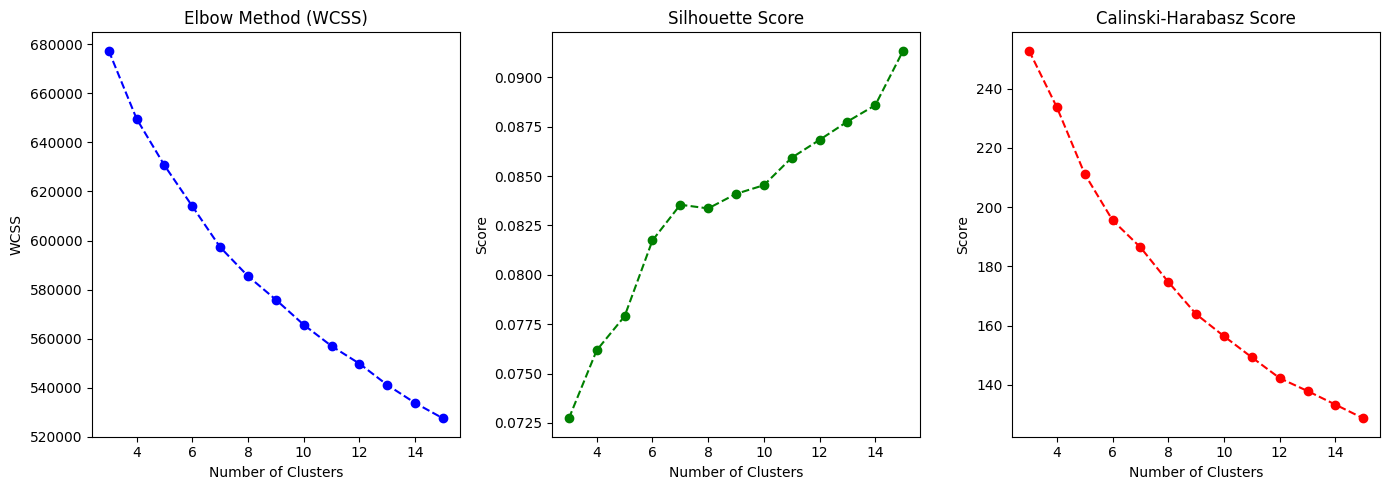

In [10]:
pca = PCA(n_components=100)  # Reduce to 50 dimensions (adjust based on explained variance)
data_reduced = pca.fit_transform(stack_data)
max_cluster = 15
silhouette_scores, calinski_harabasz_scores, wcss = evaluate_clusters(data_reduced, max_clusters=max_cluster)

# Plot metrics
plt.figure(figsize=(14, 5))

# Elbow method (WCSS)
plt.subplot(1, 3, 1)
plt.plot(range(3, max_cluster + 1), wcss[1:], marker='o', linestyle='--', color='b')
plt.title('Elbow Method (WCSS)')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')

# Silhouette Score
plt.subplot(1, 3, 2)
plt.plot(range(3, max_cluster + 1), silhouette_scores[1:], marker='o', linestyle='--', color='g')
plt.title('Silhouette Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Calinski-Harabasz Score
plt.subplot(1, 3, 3)
plt.plot(range(3, max_cluster + 1), calinski_harabasz_scores[1:], marker='o', linestyle='--', color='r')
plt.title('Calinski-Harabasz Score')
plt.xlabel('Number of Clusters')
plt.ylabel('Score')

# Adjust layout
plt.tight_layout()

# Save the figure before showing
output_path = os.path.join(mouse_path, 'figures', 'silhouette.png')
plt.savefig(output_path, dpi=300, bbox_inches='tight')

In [11]:
n_clusters = 7

# Step 2: Clustering on Reduced Data
kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # Adjust number of clusters
cluster_labels = kmeans.fit_predict(data_reduced)

# # Step 3: t-SNE for Visualization
# tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
# data_2d = tsne.fit_transform(data_reduced)

# # Plot t-SNE with cluster labels
# plt.figure(figsize=(8, 6))
# for cluster in np.unique(cluster_labels):
#     plt.scatter(data_2d[cluster_labels == cluster, 0],
#                 data_2d[cluster_labels == cluster, 1],
#                 label=f"Cluster {cluster}")
# plt.title("t-SNE Visualization after PCA")
# plt.xlabel("t-SNE Dimension 1")
# plt.ylabel("t-SNE Dimension 2")
# plt.legend()
# plt.show()

c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [12]:
import seaborn as sns
colors = sns.color_palette('hsv', n_clusters)

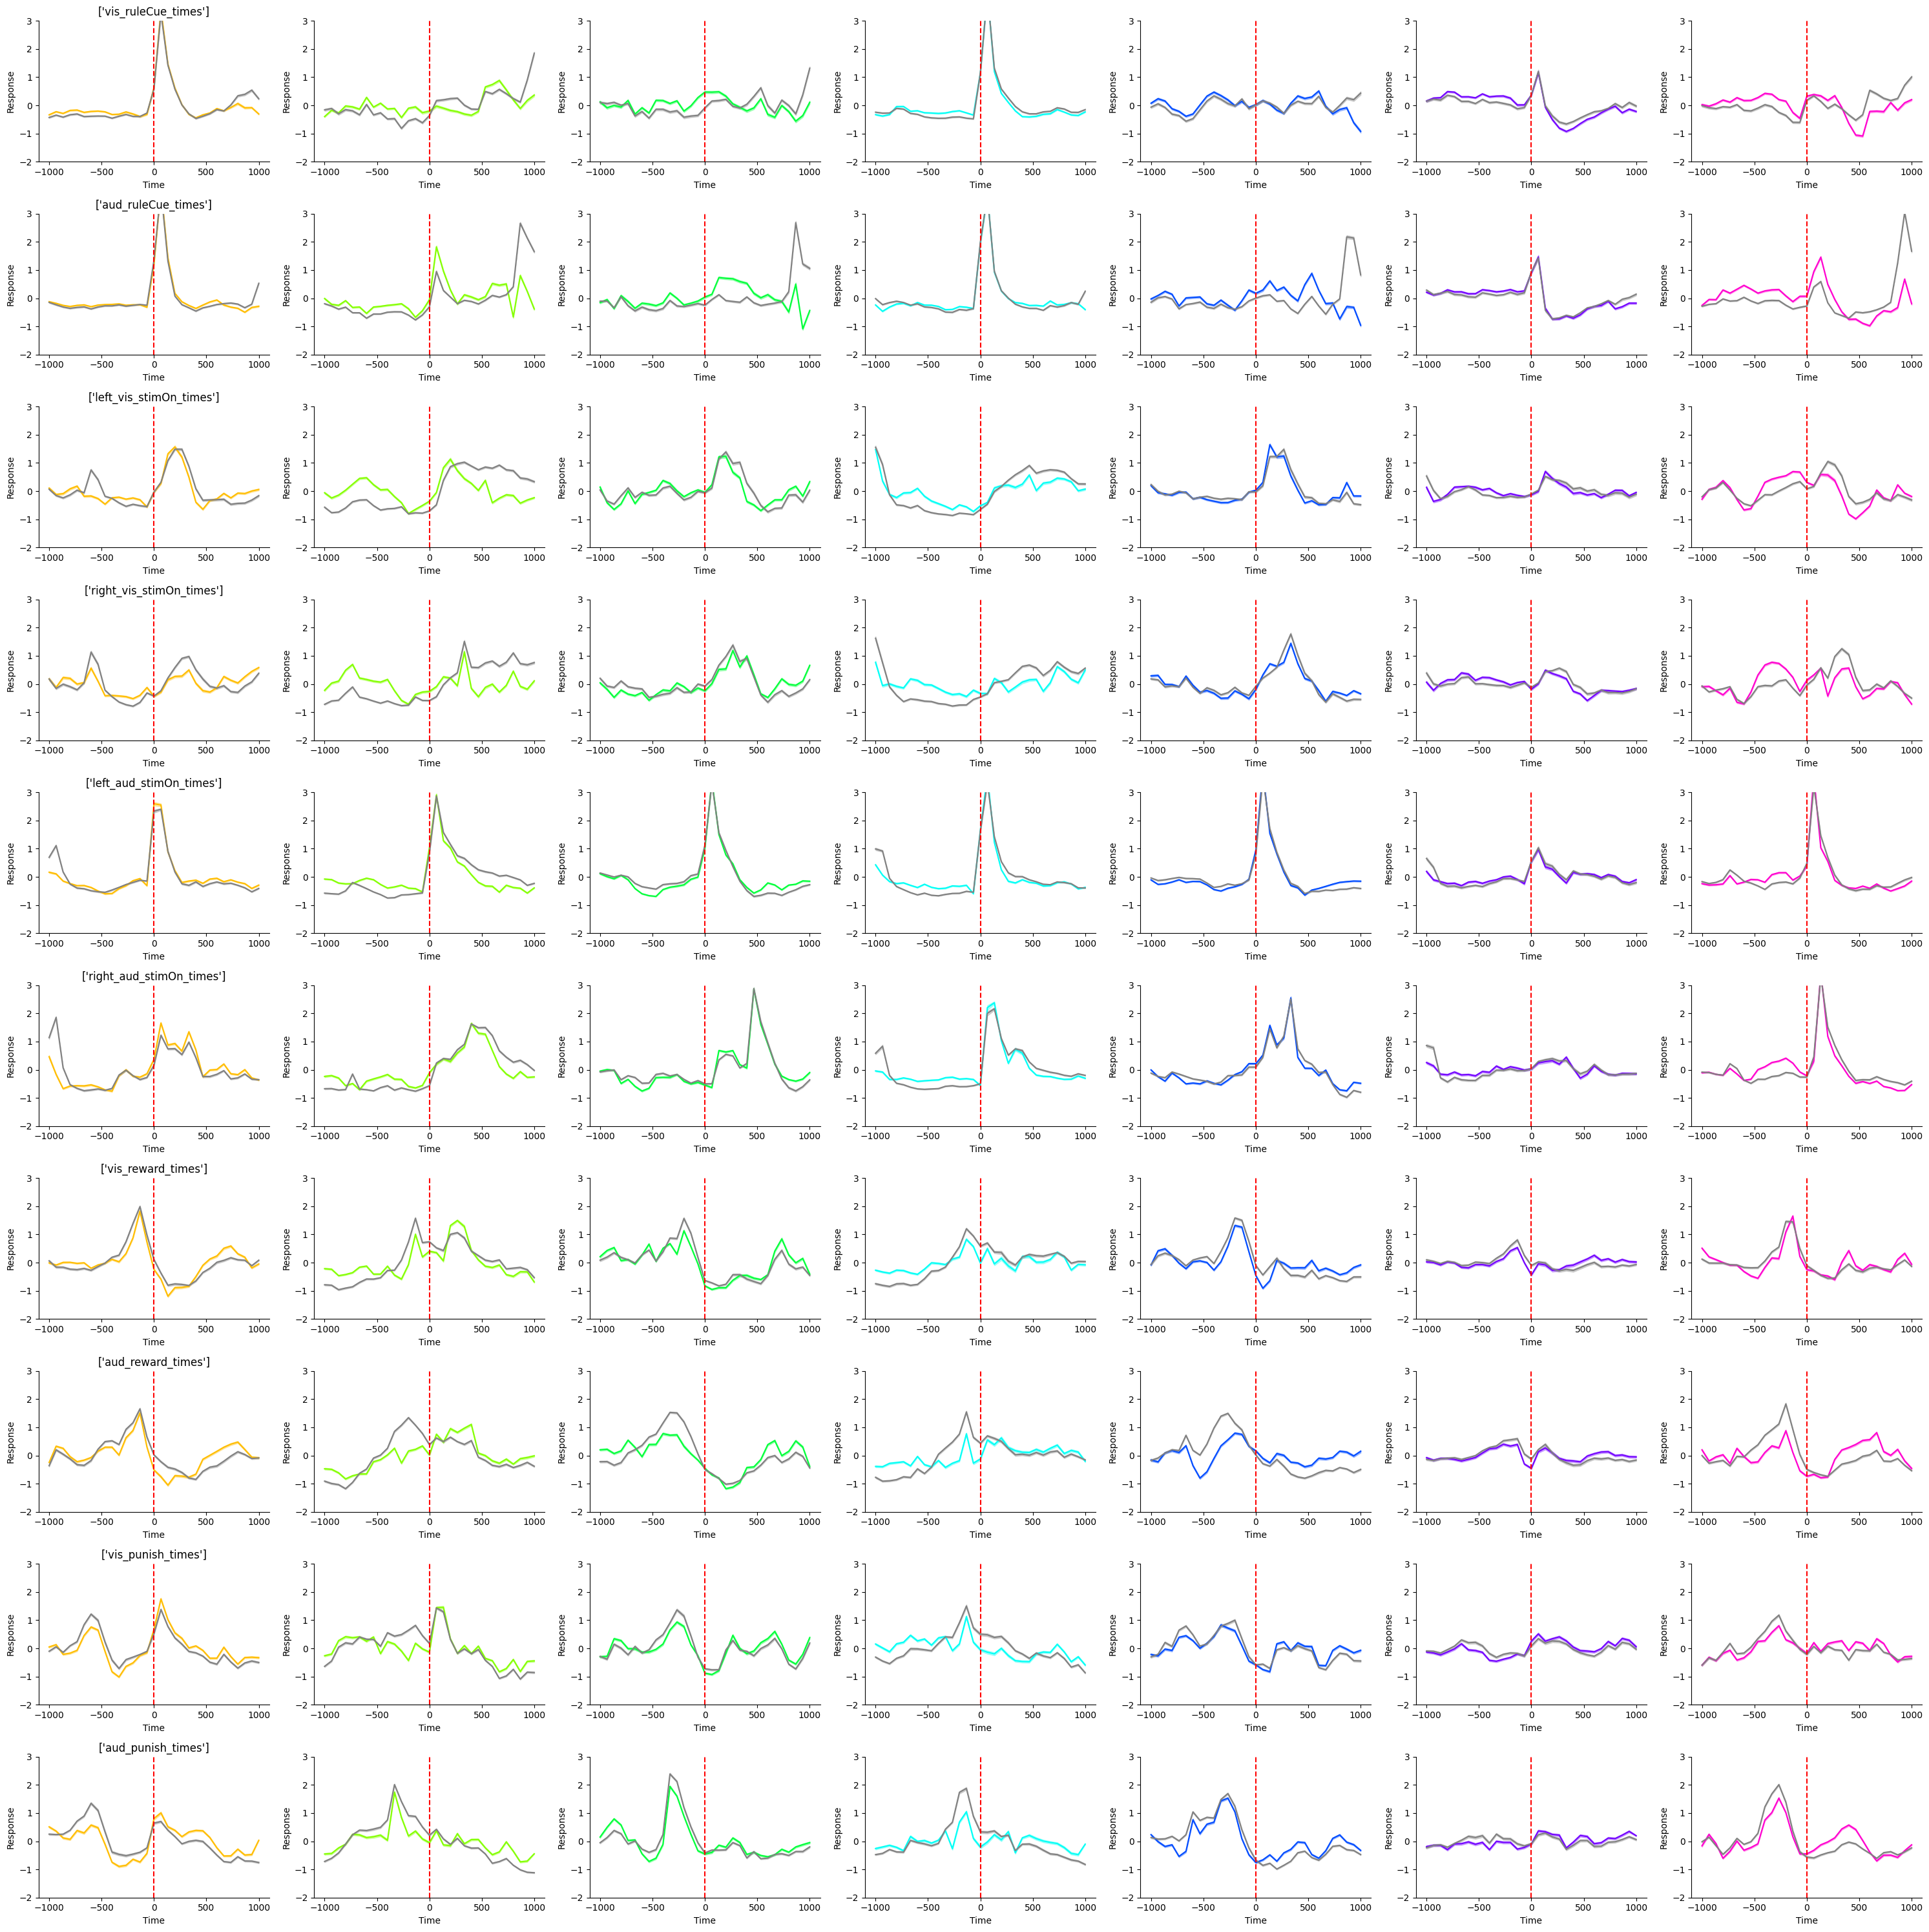

In [15]:
fig, axes = plt.subplots(len(preds), n_clusters, figsize = (30,30))

for clusi in range(n_clusters):
    clus_idx = np.where(cluster_labels == clusi)[0]
    for predi, pred in enumerate(preds):
        beta_data = neuron_data[pred+'_beta'][clus_idx]
        psth_data = neuron_data[pred+'_psth'][clus_idx]
        if clusi == 0:
            title = [pred]
        else:
            title = ''
        plot_with_error_shading(beta_data, neuron_data['beta_timepoint'], axes[predi, clusi], title=title, ymin = -2, ymax = 3, color = colors[clusi])
        plot_with_error_shading(psth_data, neuron_data['beta_timepoint'], axes[predi, clusi], title=title, ymin = -2, ymax = 3, color = (0.5,0.5,0.5))
        axes[predi, clusi].axvline(x=0, color='red', linestyle='--')
        #midpoint = np.where((neuron_data['beta_timepoint']<1) & (neuron_data['beta_timepoint']>-1))[0]
plt.tight_layout()
fig.savefig(os.path.join(mouse_path, 'figures', 'cluster_psbeta_with_psth.png'),
                dpi=300,               # High resolution for publication
                bbox_inches='tight',   # Prevent clipping
                )

C:\Users\dirk\AppData\Local\Temp\ipykernel_7628\780684590.py:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[dayi//3, dayi%3].scatter(neuron['xcoord_atlas'], neuron['ycoord_atlas'], c=color, s=0.001)
C:\Users\dirk\AppData\Local\Temp\ipykernel_7628\780684590.py:34: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[dayi//3, dayi%3].scatter(neuron['xcoord_atlas'], neuron['ycoord_atlas'], c=color, s=0.001)


KeyboardInterrupt: 

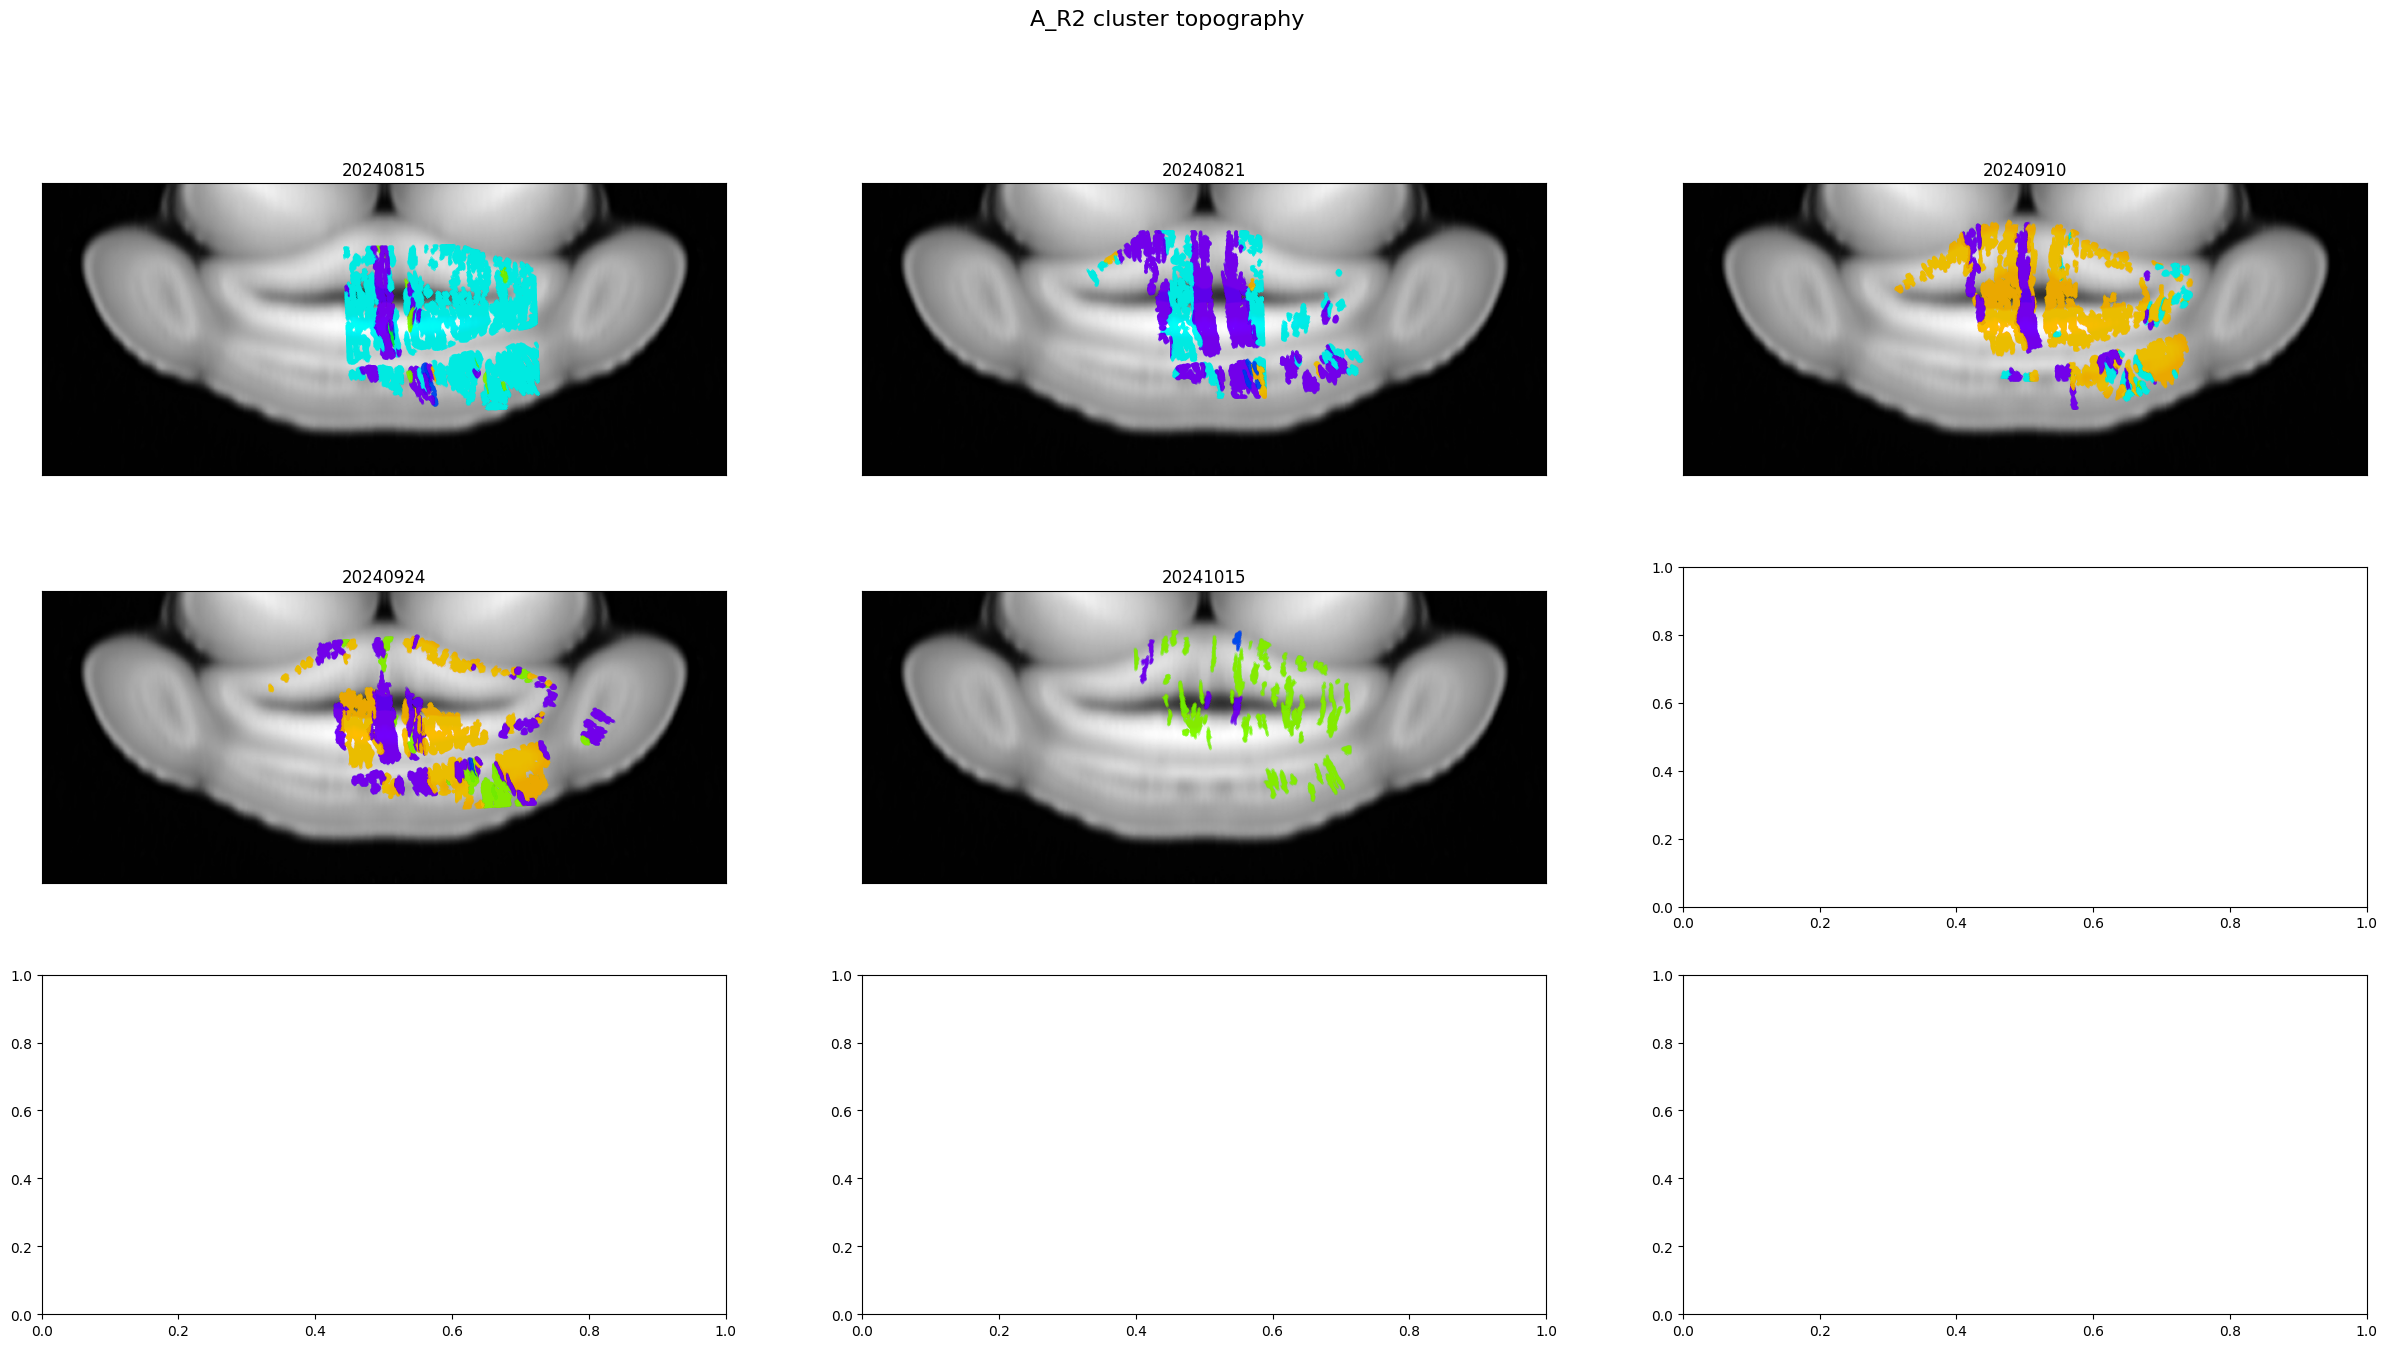

In [14]:
fig, axes = plt.subplots(3,3,figsize = (30,15))
fig.suptitle(mouse_id + ' cluster topography', fontsize=16)
for dayi, date in enumerate(dates):
    
    axes[dayi//3, dayi%3].imshow(atlas_template,cmap='gray')
    axes[dayi//3, dayi%3].set_title(date)
    axes[dayi//3, dayi%3].set_xticks([])
    axes[dayi//3, dayi%3].set_yticks([])
    neuron_date_idx = np.where(neuron_data['date'] == date)[0]
    cluster_labels_in_date = cluster_labels[neuron_date_idx]
    arm1_idx = np.where(neuron_data['arm'][neuron_date_idx] == 'arm1')[0]
    arm2_idx = np.where(neuron_data['arm'][neuron_date_idx] == 'arm2')[0]
    
    
    if 'arm1' in mouse_data[date]:
        arm1_cluster_labels = cluster_labels_in_date[arm1_idx]
        stat = mouse_data[date]['arm1']
        aspect_ratio = np.array([stat[i]['aspect_ratio'] for i in range(len(stat))])
        npix = np.array([stat[i]['npix'] for i in range(len(stat))])
        pc_idx = np.where((aspect_ratio<1.1) & (npix<120) & (npix>100))[0]
        dd_idx = np.where((aspect_ratio>1.1) | (npix>120) | (npix<100))[0]
        for i, neuron in enumerate(mouse_data[date]['arm1'][dd_idx]):
            color = colors[arm1_cluster_labels[i]]
            axes[dayi//3, dayi%3].scatter(neuron['xcoord_atlas'], neuron['ycoord_atlas'], c=color, s=0.001)
    if 'arm2' in mouse_data[date]:
        arm2_cluster_labels = cluster_labels_in_date[arm2_idx]
        stat = mouse_data[date]['arm2']
        aspect_ratio = np.array([stat[i]['aspect_ratio'] for i in range(len(stat))])
        npix = np.array([stat[i]['npix'] for i in range(len(stat))])
        pc_idx = np.where((aspect_ratio<1.1) & (npix<120) & (npix>100))[0]
        dd_idx = np.where((aspect_ratio>1.1) | (npix>120) | (npix<100))[0]
        for i, neuron in enumerate(mouse_data[date]['arm2'][dd_idx]):
            color = colors[arm2_cluster_labels[i]]
            axes[dayi//3, dayi%3].scatter(neuron['xcoord_atlas'], neuron['ycoord_atlas'], c=color, s=0.001)
fig.tight_layout()
fig.savefig(os.path.join(mouse_path, 'figures', 'cluster_topo.png'),
            dpi=300,               # High resolution for publication
            bbox_inches='tight',   # Prevent clipping
            )

In [171]:
len(arm1_cluster_labels)

219

In [4]:

resp_frame_idx = (neuron_data['beta_timepoint'] >=0) & (neuron_data['beta_timepoint'] <= 400)
arm1_vis_reward_beta_by_day = []
arm1_aud_reward_beta_by_day = []
arm2_vis_reward_beta_by_day = []
arm2_aud_reward_beta_by_day = []
for dayi, date in enumerate(dates):
    
    neuron_date_idx = np.where(neuron_data['date'] == date)[0]
    arm1_idx = np.where(neuron_data['arm'][neuron_date_idx] == 'arm1')[0]
    arm2_idx = np.where(neuron_data['arm'][neuron_date_idx] == 'arm2')[0]
    arm1_vis_reward_beta_by_day.append(neuron_data['vis_reward_times_beta'][neuron_date_idx][arm1_idx])
    arm2_vis_reward_beta_by_day.append(neuron_data['vis_reward_times_beta'][neuron_date_idx][arm2_idx])
    arm1_aud_reward_beta_by_day.append(neuron_data['aud_reward_times_beta'][neuron_date_idx][arm1_idx])
    arm2_aud_reward_beta_by_day.append(neuron_data['aud_reward_times_beta'][neuron_date_idx][arm2_idx])
    

    

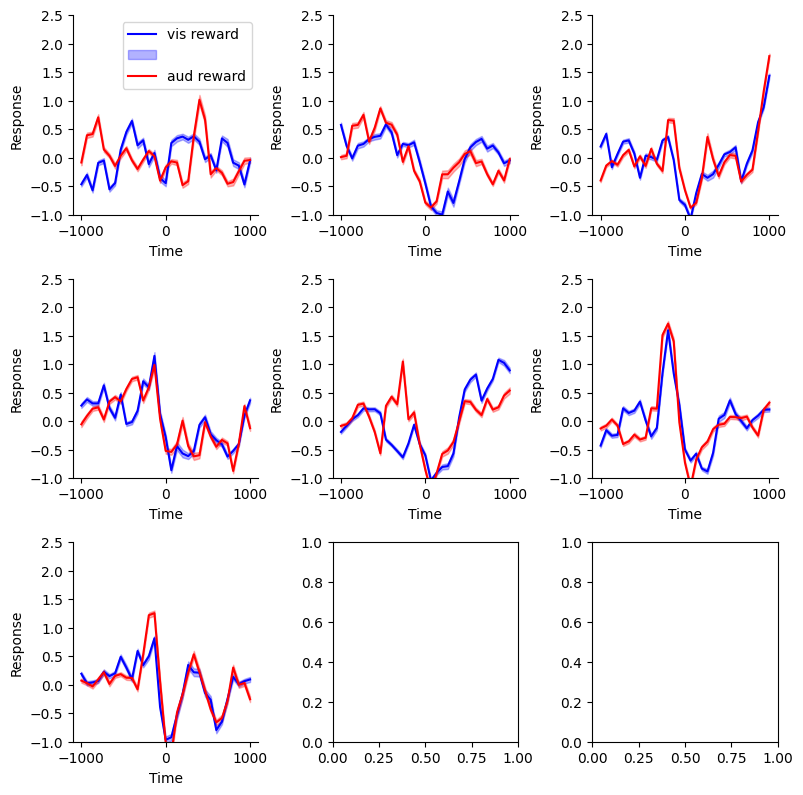

In [5]:
fig, axes = plt.subplots(3,3,figsize = (8,8))
#fig.suptitle(mouse_id + ' cluster topography', fontsize=16)
for i in range(len(arm1_vis_reward_beta_by_day)):
    row = i//3
    column = i%3
    ax = axes[row,column]
    plot_with_error_shading(data = arm1_vis_reward_beta_by_day[i], time_points = neuron_data['beta_timepoint'],ymax=2.5, ymin=-1, ax=ax, color='b')
    plot_with_error_shading(data = arm1_aud_reward_beta_by_day[i], time_points = neuron_data['beta_timepoint'],ymax=2.5, ymin=-1, ax=ax, color='r')
axes[0,0].legend(['vis reward','','aud reward'])
plt.tight_layout()
fig.savefig(os.path.join(mouse_path, 'figures', 'arm1_vis_reward_vs_aud_reward.png'),
            dpi=300,               # High resolution for publication
            bbox_inches='tight',   # Prevent clipping
            )

c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\numpy\core\_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\numpy\core\_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
c:\Users\dirk\anaconda3\envs\iblenv\lib\site-packages\numpy\core\_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


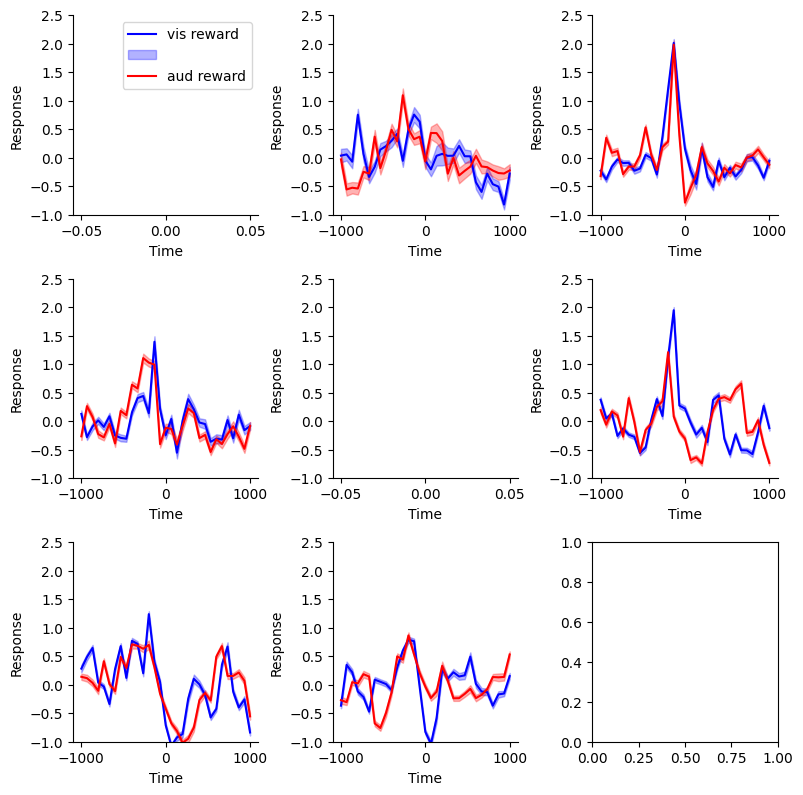

In [7]:
fig, axes = plt.subplots(3,3,figsize = (8,8))
#fig.suptitle(mouse_id + ' cluster topography', fontsize=16)
for i in range(len(arm1_vis_reward_beta_by_day)):
    row = i//3
    column = i%3
    ax = axes[row,column]
    plot_with_error_shading(data = arm2_vis_reward_beta_by_day[i], time_points = neuron_data['beta_timepoint'], ax=ax, ymax=2.5, ymin=-1, color='b')
    plot_with_error_shading(data = arm2_aud_reward_beta_by_day[i], time_points = neuron_data['beta_timepoint'], ax=ax, ymax=2.5, ymin=-1, color='r')
axes[0,0].legend(['vis reward','','aud reward'])
plt.tight_layout()
fig.savefig(os.path.join(mouse_path, 'figures', 'arm2_vis_reward_vs_aud_reward.png'),
            dpi=300,               # High resolution for publication
            bbox_inches='tight',   # Prevent clipping
            )
